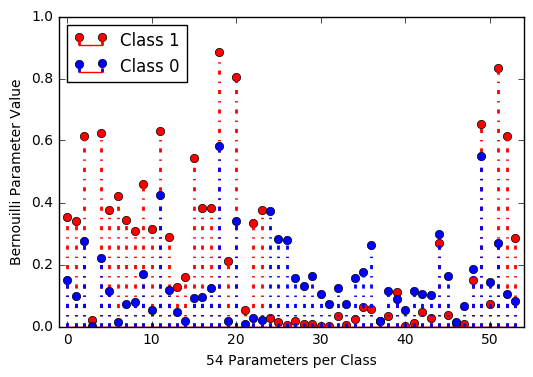

In [1]:
# Naive Bayes Classifier using 54 dimensions of bernouilli and 3 dimensions of pareto
# SPAM VS NOT SPAM CLASSIFIER

import numpy as np
import pandas as pd
from numpy import array
import math
import matplotlib.pyplot as plt

X_train = pd.read_csv('X_train.csv', sep=',', header = None)
X_test = pd.read_csv('X_test.csv', sep=',', header = None)
y_train = pd.read_csv('y_train.csv', sep=',', header = None)
y_test = pd.read_csv('y_test.csv', sep=',', header = None)

# Calculate prior distribution MLE parameter. For Bernoulli it is sample average (Probability of being class 1)
prior_theta = np.mean(y_train.values)

# Split data by class to find conditional distribution given the class
X_train_1 = X_train[0:1776] 
X_train_0 = X_train[1776:] 
y_train_1 = y_train[0:1776]
y_train_0 = y_train[1776:]
X_test_1 = X_test[0:37] 
X_test_0 = X_test[37:] 
y_test_1 = y_test[0:37]
y_test_0 = y_test[37:]

# Find MLE parameter for each dimension of our conditional training sets
def getMLE():
    thetas1 = []
    thetas0 = []
    for i in range(0,54):
        thetas1.append(np.mean(X_train_1.ix[:, i].values))
    for i in range(0,54):
        thetas0.append(np.mean(X_train_0.ix[:, i].values))
    for i in range(54,57):
        thetas1.append(1/(np.mean(np.log(X_train_1.ix[:, i].values))))
    for i in range(54,57):
        thetas0.append(1/(np.mean(np.log(X_train_0.ix[:, i].values))))
    return thetas1 , thetas0
    
def bernouilli(x, theta):
    return math.pow(theta, x) * math.pow(1-theta, 1-x)

def pareto(x, theta):
    return theta / (math.pow(x, theta+1))
 
def getProbabilityClass1(testInstance, thetas1):
    prediction = prior_theta
    for i in range(0,54):
        prediction *= bernouilli(testInstance[i], thetas1[i])
    for i in range(54, 57):
        prediction *= pareto(testInstance[i], thetas1[i])
    return prediction

def getProbabilityClass0(testInstance, thetas0):
    prediction = 1- prior_theta
    for i in range(0,54):
        prediction *= bernouilli(testInstance[i], thetas0[i])
    for i in range(54, 57):
        prediction *= pareto(testInstance[i], thetas0[i])
    return prediction

def predictClass1(X_trainGivenClass1, thetas1, thetas0):
    labels = []
    for row in X_trainGivenClass1:
        if getProbabilityClass1(row, thetas1) > getProbabilityClass0(row, thetas0):
            labels.append([1])
        elif getProbabilityClass1(row, thetas1) < getProbabilityClass0(row, thetas0):
            labels.append([0])
        else: 
            labels.append(1000000)
    return array(labels)

def predictClass0(X_trainGivenClass0, thetas1, thetas0):
    labels = []
    for row in X_trainGivenClass0:
        if getProbabilityClass1(row, thetas1) > getProbabilityClass0(row, thetas0):
            labels.append([1])
        elif getProbabilityClass1(row, thetas1) < getProbabilityClass0(row, thetas0):
            labels.append([0])
        else: 
            labels.append(10000000)
    return array(labels)

def getAccuracy(predictionsC1, predictionsC0):
    correct = 0
    total = 93
    pred_given_1 = 0
    
    for i in predictionsC1:
        if i == y_test_1.values[i]:
            correct += 1
    for i in predictionsC0:
         if i == y_test_0.values[i]:
            correct += 1   
    return correct/total


thetas1 , thetas0 = getMLE()
c1 = predictClass1(X_test_1.values, thetas1, thetas0)
c0 = predictClass0(X_test_0.values, thetas1, thetas0)
getAccuracy(c1, c0) 

markerline, stemlines, baseline = plt.stem(thetas1[0:54], '-.', label = "Class 1")
markerline2, stemlines2, baseline2 = plt.stem(thetas0[0:54], '-.', label = "Class 0")
plt.setp(stemlines, 'color', 'red', 'linewidth', 2)
plt.setp(markerline, 'color', 'red', 'linewidth', 2)
plt.setp(stemlines2, 'color', 'blue', 'linewidth', 2)
plt.setp(markerline2, 'color', 'blue', 'linewidth', 2)
plt.ylabel('Bernouilli Parameter Value')
plt.xlabel('54 Parameters per Class')
x1,x2,y1,y2 = plt.axis()
plt.axis((-1,54,y1,1))
plt.legend(loc='best')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
plt.savefig("stem.png")
plt.show()


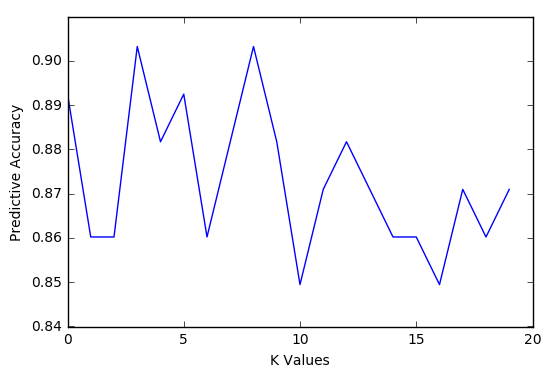

In [481]:
### KNN using L1 norm
%matplotlib inline
import scipy as sp
import numpy as np
import pandas as pd
from numpy import array
import math
import matplotlib.pyplot as plt
import operator

X_train = pd.read_csv('X_train.csv', sep=',', header = None)
X_test = pd.read_csv('X_test.csv', sep=',', header = None)
y_train = pd.read_csv('y_train.csv', sep=',', header = None)
y_test = pd.read_csv('y_test.csv', sep=',', header = None)

# Add class Labels to X_train set, each instance will now have direct access to its class label in the training set
# Add class Labels to X_test set, each instance will now have direct access to its class label in the test set
# In other words we merged X_train + y_train & X_test _ y_test
# .values converts a pandas dataframe into a numpy array
X_train = pd.concat([X_train, y_train], axis = 1).values
X_test = pd.concat([X_test, y_test], axis = 1).values


def l1_distance(x, y, length):
    distance = 0
    for i in range(length):
        distance += abs(x[i] - y[i])
    return distance

def getNeighbors(X_train, testInstance, k):
    distances = []
    length = len(testInstance)-1
    for i in range(len(X_train)):
        dist = l1_distance(testInstance, X_train[i], length)
        distances.append((X_train[i], dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for i in range(k):
        neighbors.append(distances[i][0])
    return neighbors

def getClassLabel(neighbors):
    votes = {}
    for i in range(len(neighbors)):
        label = neighbors[i][-1]
        if label in votes:
            votes[label] += 1
        else:
            votes[label] = 1
    # sort based on class votes in reverse order
    sortedVotes = sorted(votes.items(), key=operator.itemgetter(1), reverse=True)
    # Figure out how to break ties here
    return sortedVotes[0][0]

def getAccuracy(testSet, classLabels):
    correct = 0
    total = 93
    for i in range(len(testSet)):
        if testSet[i][-1] == classLabels[i]:
            correct += 1
    return correct/total

accuracyArray = []

for k in range(1,21):
    classLabels = []
    for i in range(len(X_test)):
        neighbors = getNeighbors(X_train, X_test[i], k)
        label = getClassLabel(neighbors)
        classLabels.append(label)
        print('> predicted=' + repr(label) + ', actual=' + repr(X_test[i][-1]))
    accuracy = getAccuracy(X_test, classLabels)
    accuracyArray.append(accuracy)

# Accuracies :  [0.8924731182795699, 0.8602150537634409, 
# 0.8602150537634409, 0.9032258064516129, 0.8817204301075269, 
# 0.8924731182795699, 0.8602150537634409, 0.8817204301075269, 
# 0.9032258064516129, 0.8817204301075269, 0.8494623655913979, 
# 0.8709677419354839, 0.8817204301075269, 0.8709677419354839, 
# 0.8602150537634409, 0.8602150537634409, 0.8494623655913979, 
# 0.8709677419354839, 0.8602150537634409, 0.8709677419354839]

# plt.plot(accuracyArray)
# plt.ylabel('Predictive Accuracy')
# plt.xlabel('K Values')
# plt.show()
    

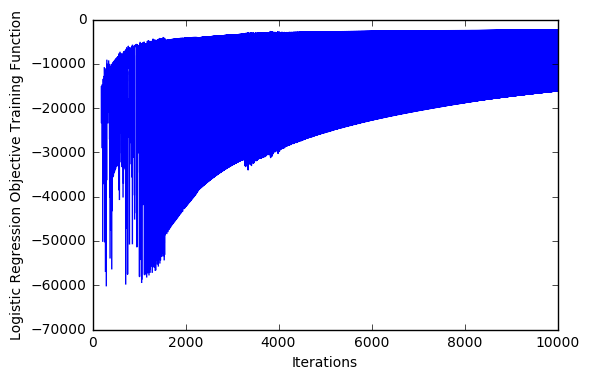

array([[-0.02098504],
       [ 0.05531541],
       [-0.0440155 ],
       [ 0.01247279],
       [ 0.12835458],
       [ 0.09970535],
       [ 0.39408984],
       [ 0.17594523],
       [ 0.07874498],
       [ 0.02293724],
       [ 0.17911318],
       [-0.3754914 ],
       [ 0.00432183],
       [ 0.01541396],
       [ 0.10996438],
       [ 0.33150126],
       [ 0.14037665],
       [ 0.07790276],
       [-0.39320255],
       [ 0.15234956],
       [ 0.00366053],
       [ 0.03434472],
       [ 0.27396099],
       [ 0.34425248],
       [-0.85930816],
       [-0.63122864],
       [-0.57561052],
       [-0.33115611],
       [-0.2629037 ],
       [-0.34397832],
       [-0.2222269 ],
       [-0.14559534],
       [-0.27617861],
       [-0.14419189],
       [-0.33955096],
       [-0.32570386],
       [-0.60415679],
       [-0.02458303],
       [-0.2366143 ],
       [-0.08018776],
       [-0.12667326],
       [-0.25635392],
       [-0.19751396],
       [-0.21120408],
       [-0.37662007],
       [-0

In [816]:
# Logistic Regression

import numpy as np
import pandas as pd
import scipy as sp
import math
import matplotlib.pyplot as plt
from numpy import array


X_train = pd.read_csv('X_train.csv', sep=',', header = None)
X_test = pd.read_csv('X_test.csv', sep=',', header = None)
y_train = pd.read_csv('y_train.csv', sep=',', header = None)
y_test = pd.read_csv('y_test.csv', sep=',', header = None)

train_ones = pd.DataFrame(np.ones((4508,), dtype=np.int))
test_ones = pd.DataFrame(np.ones((93,), dtype=np.int))

X_train = pd.concat([X_train, train_ones], axis = 1).values
X_test = pd.concat([X_test, test_ones], axis = 1).values

# replace 0 class with -1 in y[i]
y_train = y_train.replace(0, -1).values
y_test = y_test.replace(0, -1).values


# scipy.special.expit(x)


zero = np.zeros((58,1), dtype=np.int)


def updateCoefficients(X_train, w):
    objectiveArray = []
    objectiveArray.append(np.sum(np.log(sigmoid(w)), axis = 0))
    for i in range(1, 10001):
        stepSize = 1 / (pow(10, 5) * math.sqrt(i+1))
        yx = np.multiply(y_train, X_train)
        neg_sig = np.subtract(1, sigmoid(w))
        matrix = np.multiply(neg_sig, yx)
        summation = np.sum(matrix, axis = 0)
        x = np.multiply(stepSize, summation)    
        w = np.add(w,x.reshape(58,1))
        obj = np.sum(np.log(sigmoid(w)), axis = 0)
        objectiveArray.append(obj)
    plt.plot(objectiveArray)
    plt.ylabel("Logistic Regression Objective Training Function")
    plt.xlabel("Iterations")
    plt.show()
    return w

def sigmoid(w):
    yx = np.multiply(y_train, X_train)
    xTw = np.matmul(yx, w)
    return sp.special.expit(xTw)


updateCoefficients(X_train, zero)


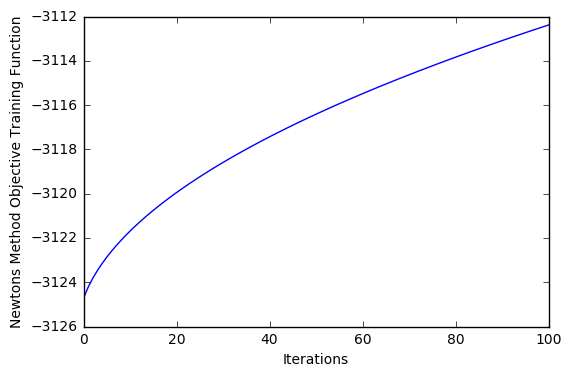

array([[ -7.25180603e-04],
       [ -3.80878730e-05],
       [ -4.01288893e-04],
       [  1.15649351e-03],
       [  1.50820800e-03],
       [ -2.77655954e-06],
       [  3.26972282e-03],
       [  1.15265443e-03],
       [  4.63415680e-05],
       [  3.89340482e-05],
       [ -5.91338314e-04],
       [ -6.60754979e-04],
       [ -1.12406346e-03],
       [ -4.36246333e-04],
       [  6.04467768e-04],
       [  2.46672870e-03],
       [  6.74345382e-04],
       [  3.04141921e-05],
       [  6.10528631e-04],
       [  9.48987521e-06],
       [  1.27562576e-03],
       [  2.01658230e-03],
       [  7.23307658e-04],
       [  1.86463946e-03],
       [ -3.36895942e-03],
       [ -8.98587897e-05],
       [ -3.25526761e-03],
       [  1.30946103e-03],
       [  1.54551541e-04],
       [ -2.01995826e-04],
       [ -1.67362534e-03],
       [  1.48727632e-03],
       [ -3.83656127e-04],
       [  1.85637454e-03],
       [ -8.81143654e-04],
       [  4.97241702e-04],
       [ -1.11084218e-03],
 

In [896]:
# Newtons Method

import numpy as np
import pandas as pd
import scipy as sp
import math
import matplotlib.pyplot as plt
from numpy import array


X_train = pd.read_csv('X_train.csv', sep=',', header = None)
X_test = pd.read_csv('X_test.csv', sep=',', header = None)
y_train = pd.read_csv('y_train.csv', sep=',', header = None)
y_test = pd.read_csv('y_test.csv', sep=',', header = None)

train_ones = pd.DataFrame(np.ones((4508,), dtype=np.int))
test_ones = pd.DataFrame(np.ones((93,), dtype=np.int))

X_train = pd.concat([X_train, train_ones], axis = 1).values
X_test = pd.concat([X_test, test_ones], axis = 1).values

# replace 0 class with -1 in y[i]
y_train = y_train.replace(0, -1).values
y_test = y_test.replace(0, -1).values

zero = np.zeros((58,1), dtype=np.int)


def updateCoefficients(X_train, w):
    objectiveArray = []
    objectiveArray.append(np.sum(np.log(sigmoid(w)), axis = 0))
    for i in range(1, 101):
        stepSize = 1 / (math.sqrt(i+1))
        yx = np.multiply(y_train, X_train)
        neg_sig = np.subtract(1, sigmoid(w))
        matrix = np.multiply(neg_sig, yx)
        L = np.sum(matrix, axis = 0) 
        
        xTx = np.matmul(X_train.T, X_train)
        neg_sig2 = np.subtract(1, sigmoid(w))    
        multi1 = np.sum(np.multiply(sigmoid(w), neg_sig2), axis = 0)
        multi2 = np.multiply(multi1, xTx)
#         summation = np.sum(multi2, axis = 0)
        L2 = np.multiply(-1, multi2)
        inverse = np.linalg.inv(L2)
        L1L2 = np.matmul(inverse, L) 
        step = np.multiply(stepSize, L1L2)
        
        w = np.subtract(w, step.reshape(58,1))
        obj = np.sum(np.log(sigmoid(w)), axis = 0)
        objectiveArray.append(obj)
    plt.plot(objectiveArray)
    plt.ylabel("Newtons Method Objective Training Function")
    plt.xlabel("Iterations")
    plt.show()
#     accuracy = getAccuracy(X_test, y_test, w)
#     print(accuracy)
    return w


def sigmoid(w):
    yx = np.multiply(y_train, X_train)
    xTw = np.matmul(yx, w)
    return sp.special.expit(xTw)

def sigmoid2(w):
    xTw = np.matmul(X_train, w)
    return sp.special.expit(xTw)

def sigmoid2test(w):
    xTw = np.matmul(X_test, w)
    return sp.special.expit(xTw)

def getAccuracy(X_test, y_test, w):
    correct = 0
    total = 93
    predictions = sigmoid2(w)
    for i in range(len(X_test)):
        if predictions[i] > 0:
            if (y_test[i] == 1):
                correct += 1
        if predictions[i] < 0:
            if (y_test[i] == -1):
                correct += 1
    return correct/total

updateCoefficients(X_train, zero)
# w = updateCoefficients(X_train, zero)
# accuracy = getAccuracy(X_test, y_test, w)
# accuracy

